# Network Analysis

## 1.1 Centrality Measures
Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in 
the underground network. Give the definition of each of the measures (including their equation), put 
the measures into the context of the underground, and why they will allow you to find the stations that 
are most crucial for the functioning of the underground. Compute the measures for your nodes in the 
network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.  

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from operator import itemgetter
import copy
import warnings
warnings.filterwarnings('ignore')

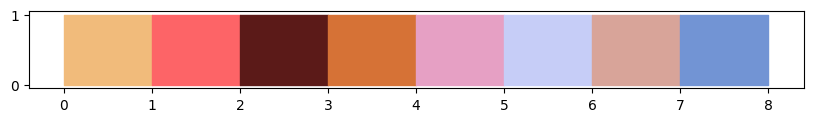

In [3]:
# Now import my favourite colour palette:
gbp_colors = ["#F1BB7B", "#FD6467", "#5B1A18", "#D67236", "#E6A0C4", "#C6CDF7", "#D8A499", "#7294D4"]

# Now let's plot color pallette
plt.figure(figsize=(10, 1))
for i, color in enumerate(gbp_colors):
    plt.fill_between([i, i + 1], 0, 1, color=color)


### 1.1.0 Read the data, and explore the network:

In [4]:
# make multiple copies of the graph
london_graph = nx.read_graphml('london_updated.graph')
london_graph3a = nx.read_graphml('london_updated.graph')
london_graph3b = nx.read_graphml('london_updated.graph')

In [5]:
# convert str into tuple:
for node in london_graph.nodes():
    london_graph.nodes[node]['coords'] = eval(london_graph.nodes[node]['coords'])

In [6]:
# convert str into tuple:
for node in london_graph3a.nodes():
    london_graph3a.nodes[node]['coords'] = eval(london_graph3a.nodes[node]['coords'])

In [7]:
# convert Str into tuple:
for node in london_graph3b.nodes():
    london_graph3b.nodes[node]['coords'] = eval(london_graph3b.nodes[node]['coords'])

In [8]:
# Take a look at our data
print("number of nodes: ",london_graph.number_of_nodes())
print("number of edges: ",london_graph.number_of_edges())

number of nodes:  401
number of edges:  467


In [9]:
list(london_graph.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [10]:
# To check edges attributes:
list(london_graph.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.771558050728, 'line_name': 'Jubilee', 'flows': 12356})

In [11]:
counter = 0
# Iterate through each node and print its attributes
for node, attrs in london_graph.nodes(data=True):
    print(f"Node: {node}, Attributes: {attrs}")
   
    # check first 10
    counter += 1
    if counter == 10:
        break  # Exit the loop

Node: Wembley Park, Attributes: {'coords': (519316.5590174915, 186389.32981656672)}
Node: Kingsbury, Attributes: {'coords': (519359.9688603217, 188721.22027255013)}
Node: Queensbury, Attributes: {'coords': (518811.3613368616, 189760.50737704366)}
Node: Canons Park, Attributes: {'coords': (518183.29968291725, 191257.26260848)}
Node: Stanmore, Attributes: {'coords': (517580.4596464033, 192537.99948098673)}
Node: Stratford, Attributes: {'coords': (538524.7855297636, 184373.34100822973)}
Node: West Ham, Attributes: {'coords': (539160.2577659411, 182933.29006798862)}
Node: Canning Town, Attributes: {'coords': (539439.020753582, 181338.40907066417)}
Node: North Greenwich, Attributes: {'coords': (539189.2108512281, 179809.60035511584)}
Node: Canary Wharf, Attributes: {'coords': (537586.6947649193, 180311.85419390627)}


Plot the entire network:

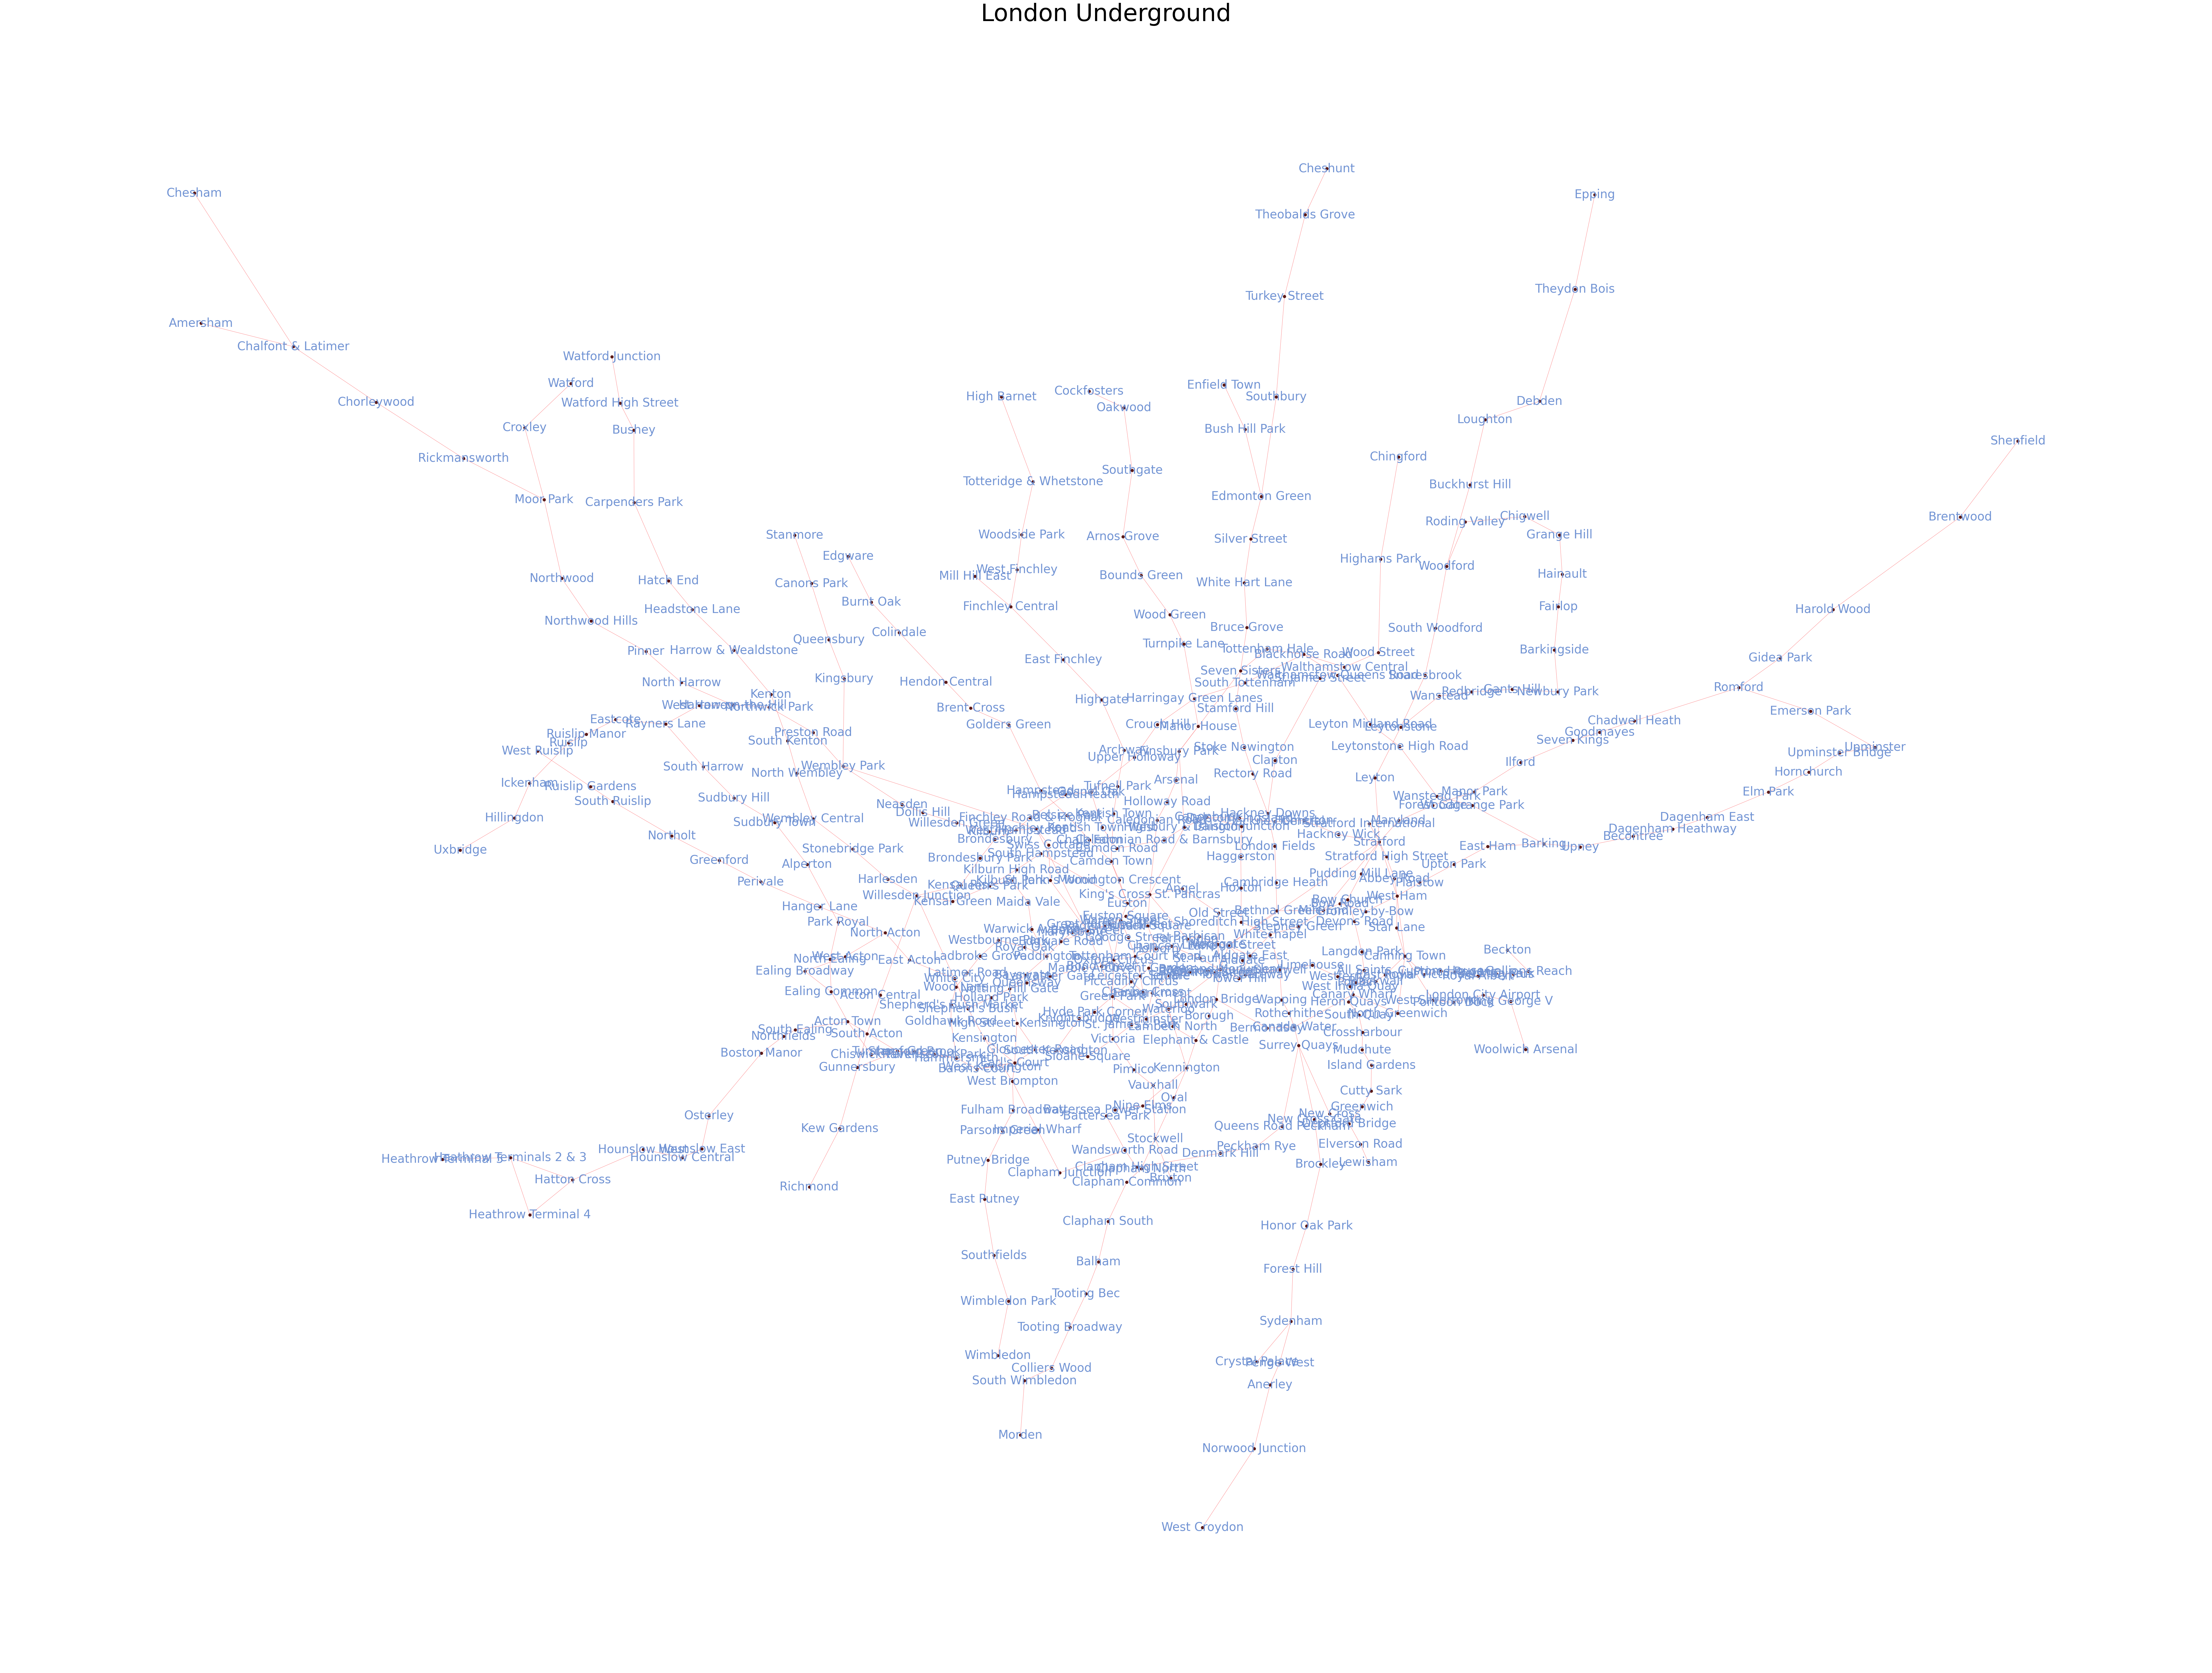

In [31]:
fig, ax = plt.subplots(figsize=(100,75))

node_labels = {node: node for node in london_graph.nodes()}
pos = nx.get_node_attributes(london_graph, 'coords')

nx.draw_networkx_nodes(london_graph, pos, node_size=50, node_color=gbp_colors[2])
nx.draw_networkx_edges(london_graph, pos, arrows=False, width=0.6, edge_color=gbp_colors[1])
nx.draw_networkx_labels(london_graph, pos, node_labels, font_size=30, font_color=gbp_colors[7])

plt.title("London Underground",fontsize=60)
plt.axis("off")
plt.show()

In [32]:
network_df = nx.to_pandas_edgelist(london_graph)

In [33]:
network_df.head()

source         target     line_name  flows       length
0  Wembley Park      Kingsbury       Jubilee  12356  2916.771558
1  Wembley Park        Neasden       Jubilee   6744  2353.165938
2  Wembley Park   Preston Road  Metropolitan  36600  1419.735166
3  Wembley Park  Finchley Road  Metropolitan  55215  7266.373927
4     Kingsbury     Queensbury       Jubilee   9419  1245.995234

### 1.1.1 Calculate Three Centrality Measures
degree, betweenness / delta, closeness

In [34]:
degree_centrality = nx.degree_centrality(london_graph)

nx.set_node_attributes(london_graph,dict(degree_centrality),'degree_centrality')


# To dataframe using the nodes as the index
df_deg = pd.DataFrame(index=london_graph.nodes())

#
df_deg['degree_centrality'] = pd.Series(nx.get_node_attributes(london_graph, 'degree_centrality'))

df_deg_sorted = df_deg.sort_values(["degree_centrality"], ascending=False)
df_deg_sorted[0:10]

degree_centrality
Stratford                            0.0225
Bank and Monument                    0.0200
Baker Street                         0.0175
King's Cross St. Pancras             0.0175
Green Park                           0.0150
Liverpool Street                     0.0150
Oxford Circus                        0.0150
Earl's Court                         0.0150
West Ham                             0.0150
Canning Town                         0.0150

In [35]:
df_deg_sorted
# convert index to column
df_deg_sorted.reset_index(level=0, inplace=True)
df_deg_sorted.rename(columns = {'index':'station_name'}, inplace = True)

In [36]:
df_deg_sorted.to_csv('degree_centrality.csv')

In [37]:
# save column to a list:df_deg['degree_centrality']
df_deg_sorted['degree_centrality'].max()

0.0225

In [38]:
betweenness_centrality = nx.betweenness_centrality(london_graph)
nx.set_node_attributes(london_graph,dict(betweenness_centrality),'betweenness_centrality')
# To dataframe using the nodes as the index
df_bet = pd.DataFrame(index=london_graph.nodes())
df_bet ['betweenness_centrality'] = pd.Series(nx.get_node_attributes(london_graph, 'betweenness_centrality'))
df_bet_sorted = df_bet.sort_values(["betweenness_centrality"], ascending=False)
df_bet_sorted[0:10]

betweenness_centrality
Stratford                               0.297846
Bank and Monument                       0.290489
Liverpool Street                        0.270807
King's Cross St. Pancras                0.255307
Waterloo                                0.243921
Green Park                              0.215835
Euston                                  0.208324
Westminster                             0.203335
Baker Street                            0.191568
Finchley Road                           0.165085

In [39]:
# function to calculate the delta centrality defined in our lecture.
def delta_calc(input_graph):
    """
     
    """
    
    delta_centrality = {}

    original_efficiency = nx.global_efficiency(input_graph)

    for node in input_graph.nodes():
        

        graph_copy = copy.deepcopy(input_graph)
            
        graph_copy.remove_node(node)

        # Calculate the efficiency of the graph after removing the node
        removed_efficiency = nx.global_efficiency(graph_copy)

        # Calculate information centrality
        delta_centrality[node] = (original_efficiency - removed_efficiency) / original_efficiency

    return delta_centrality

In [26]:
delta_centrality = delta_calc(london_graph)
sorted_delta = sorted(delta_centrality.items(), key=lambda x: x[1], reverse=True)

__Delta centrality defined in our module__

In [27]:
df_delta = pd.DataFrame(sorted_delta, columns=['Station', 'Delta_Centrality'])
df_delta = df_delta.set_index('Station')

In [30]:
df_delta.head(10)

Delta_Centrality
Station                             
Stratford                   0.121858
Euston                      0.091412
Camden Town                 0.071379
Leyton                      0.067141
Leytonstone                 0.062154
Canning Town                0.057365
Willesden Junction          0.052124
Finsbury Park               0.046411
Surrey Quays                0.045374
Wembley Park                0.044668

In [21]:
# add the delta_centrality back to the graph
nx.set_node_attributes(london_graph, delta_centrality, 'delta_centrality')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


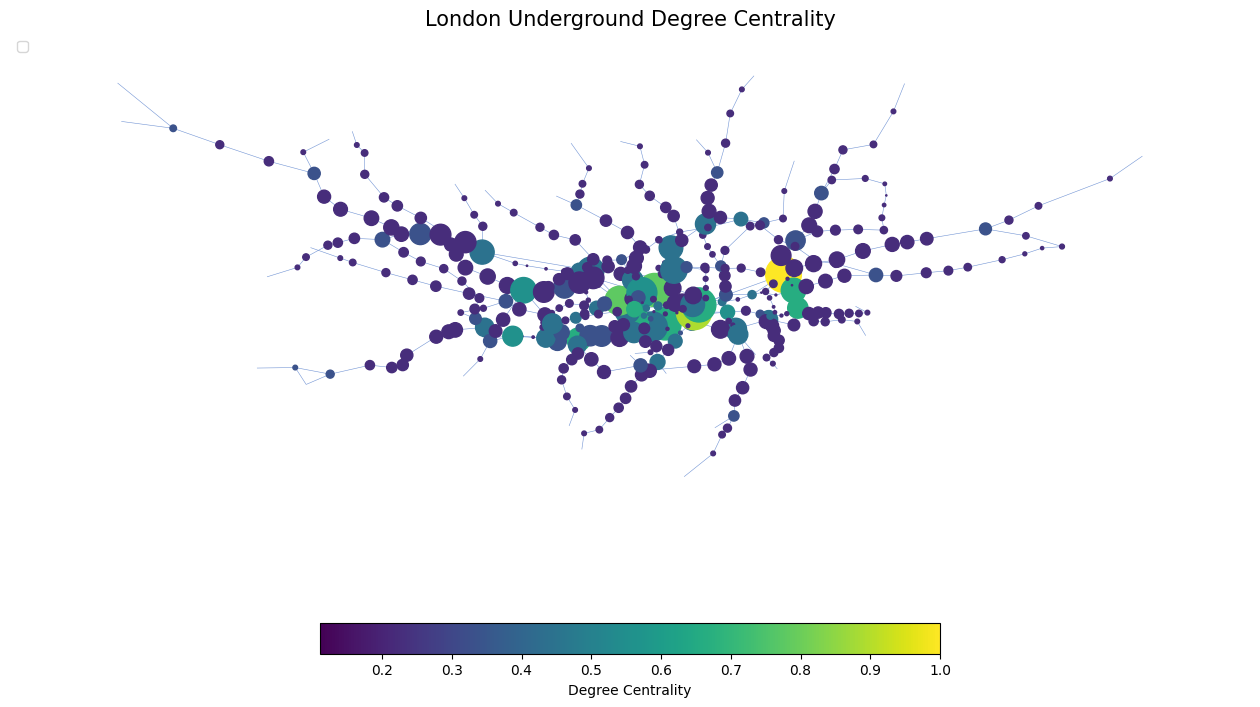

In [ ]:
degree_centrality_values=list(map(lambda i: i[1]['degree_centrality'], london_graph.nodes(data=True)))

max_degree = df_deg_sorted['degree_centrality'].max()
nd_color =list(map(lambda i: i[1]['degree_centrality'] / max_degree, london_graph.nodes(data=True)))
# use size to represet delta centrality:
nd_size = list(map(lambda i: (i[1]['betweenness_centrality'] / max_degree) * 50, london_graph.nodes(data=True)))
#nd_size = list(map(lambda i: (i[1]['delta_centrality'] / max_degree) * 50, london_graph.nodes(data=True)))

# plot top 10 nodes with highest degree centrality
fig, ax = plt.subplots(figsize=(16,9))

pos = nx.get_node_attributes(london_graph, 'coords')

nx.draw_networkx_edges(london_graph, pos, edge_color=grandBudapest_colors[7], 
        width=0.4)
nod = nx.draw_networkx_nodes(london_graph,
        pos = pos,
        node_color= nd_color,
        node_size= nd_size)

plt.colorbar(nod,
             label="Degree Centrality",
             orientation="horizontal", 
             shrink=0.5)
# add legend for size of nodes
plt.legend(numpoints=1, loc='upper left')    

plt.axis("off")
plt.title("London Underground Degree Centrality",fontsize=15)
plt.show()

In [ ]:
closeness_centrality = nx.closeness_centrality(london_graph)
nx.set_node_attributes(london_graph,dict(closeness_centrality),'closeness_centrality')
# To dataframe using the nodes as the index
df_close = pd.DataFrame(index=london_graph.nodes())
df_close['closeness_centrality'] = pd.Series(nx.get_node_attributes(london_graph, 'closeness_centrality'))
df_close_sorted = df_close.sort_values(["closeness_centrality"], ascending=False)
df_close_sorted[0:10]

## 1.2 Impact Measures
Find 2 different measures to evaluate the impact of the node removal on the network. These need to 
be global measures referring to the whole network and not to specific nodes or links. Explain whether 
these two measures are specific to the London underground, or whether they could also be used to 
evaluate the resilience of any other network.
  
https://www.youtube.com/watch?v=P0PBsRASneU

In [24]:
 #We can print the dataframe from the shapefile to check the data
df_edge = nx.to_pandas_edgelist(london_graph)
df_edge[0:20]

source                   target           line_name   flows  \
0   Wembley Park                Kingsbury             Jubilee   12356   
1   Wembley Park                  Neasden             Jubilee    6744   
2   Wembley Park             Preston Road        Metropolitan   36600   
3   Wembley Park            Finchley Road        Metropolitan   55215   
4      Kingsbury               Queensbury             Jubilee    9419   
5     Queensbury              Canons Park             Jubilee    6385   
6    Canons Park                 Stanmore             Jubilee    3624   
7      Stratford                 West Ham             Jubilee   91911   
8      Stratford    Stratford High Street                 DLR    1484   
9      Stratford        Pudding Mill Lane                 DLR    4606   
10     Stratford  Stratford International                 DLR    3833   
11     Stratford         Liverpool Street            TfL Rail  160275   
12     Stratford                 Maryland            TfL Rail   34442   
13     Stratford                 Mile End             Central    6285   
14     Stratford                   Leyton             Central   56082   
15     Stratford             Hackney Wick   London Overground    9891   
16      West Ham             Canning Town             Jubilee   60452   
17      West Ham               Abbey Road                 DLR     601   
18      West Ham                Star Lane                 DLR    1038   
19      West Ham           Bromley-by-Bow  Hammersmith & City    4266   

         length  
0   2916.771558  
1   2353.165938  
2   1419.735166  
3   7266.373927  
4   1245.995234  
5   1693.307343  
6   1419.669476  
7   1673.509515  
8    519.300074  
9   1137.033257  
10  1321.068117  
11  6698.461270  
12   951.304721  
13  2805.001392  
14  2131.342926  
15  1572.923279  
16  1695.080746  
17   533.842422  
18   863.651663  
19  1212.245543

In [ ]:
#if want to know what is the maximum distance between stations
max_dist=max({weight for e1, e2, weight in london_graph.edges(data='length')})

#This distance in given in meters
#if want to know the name of stations which are further away from each other
furthest_stat = [(d['station_1_'],d['station_2_']) for  u,v,d in london_graph.edges(data=True) if d['length'] == max_dist]

#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(d['station_1_'],d['station_2_']) for  u,v,d in london_graph.edges(data=True) if d['station_1_'] == 'Baker Street'or d['station_2_'] == 'Baker Street']
(max_dist,furthest_stat,Baker_Street)

Largest Connected Component (LCC): This measures the size of the largest remaining connected subgraph after node removal. A smaller LCC indicates a more fragmented network.
  
Efficiency: This measures the average shortest path length between all pairs of nodes in the network. A lower efficiency indicates longer paths and reduced connectivity.

## 1.3 Node Removal
For each of the centrality measures selected in I.1. remove at least 10 nodes following two different 
strategies. A) Non-sequential removal: using the table created in I.1. remove 1 node at a time 
following the rank in the table, i.e. from the most important one to the 10

th most important one. After 
each removal, evaluate the impact of the removal using your two measures in I.2. and proceed until 
you have removed at least 10 nodes. B) Sequential: remove the highest ranked node and evaluate the 
impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest 
ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. 

Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality 
measure reflects better the importance of a station for the functioning of the underground, which 
strategy is more effective at studying resilience, and which impact measure is better at assessing the 
damage after node removal.  

In [44]:
degree_centrality
sorted_nodes_by_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
top_10_nodes_by_degree = [node for node, _ in sorted_nodes_by_degree[:20]]


In [32]:
# select top 20 values in sorted_nodes_by_degree:
top_20_nodes_by_degree = sorted_nodes_by_degree[:20]

In [38]:
top_20_nodes_by_degree

[('Stratford', 0.0225),
 ('Bank and Monument', 0.02),
 ('Baker Street', 0.0175),
 ("King's Cross St. Pancras", 0.0175),
 ('West Ham', 0.015),
 ('Canning Town', 0.015),
 ('Waterloo', 0.015),
 ('Green Park', 0.015),
 ("Earl's Court", 0.015),
 ('Liverpool Street', 0.015),
 ('Oxford Circus', 0.015),
 ('Shadwell', 0.0125),
 ('Turnham Green', 0.0125),
 ('Euston', 0.0125),
 ('Willesden Junction', 0.0125),
 ('Wembley Park', 0.01),
 ('Canary Wharf', 0.01),
 ('Canada Water', 0.01),
 ('London Bridge', 0.01),
 ('Westminster', 0.01)]

Stratford
Bank and Monument
Baker Street
King's Cross St. Pancras
West Ham
Canning Town
Waterloo
Green Park
Earl's Court
Liverpool Street


## 3a

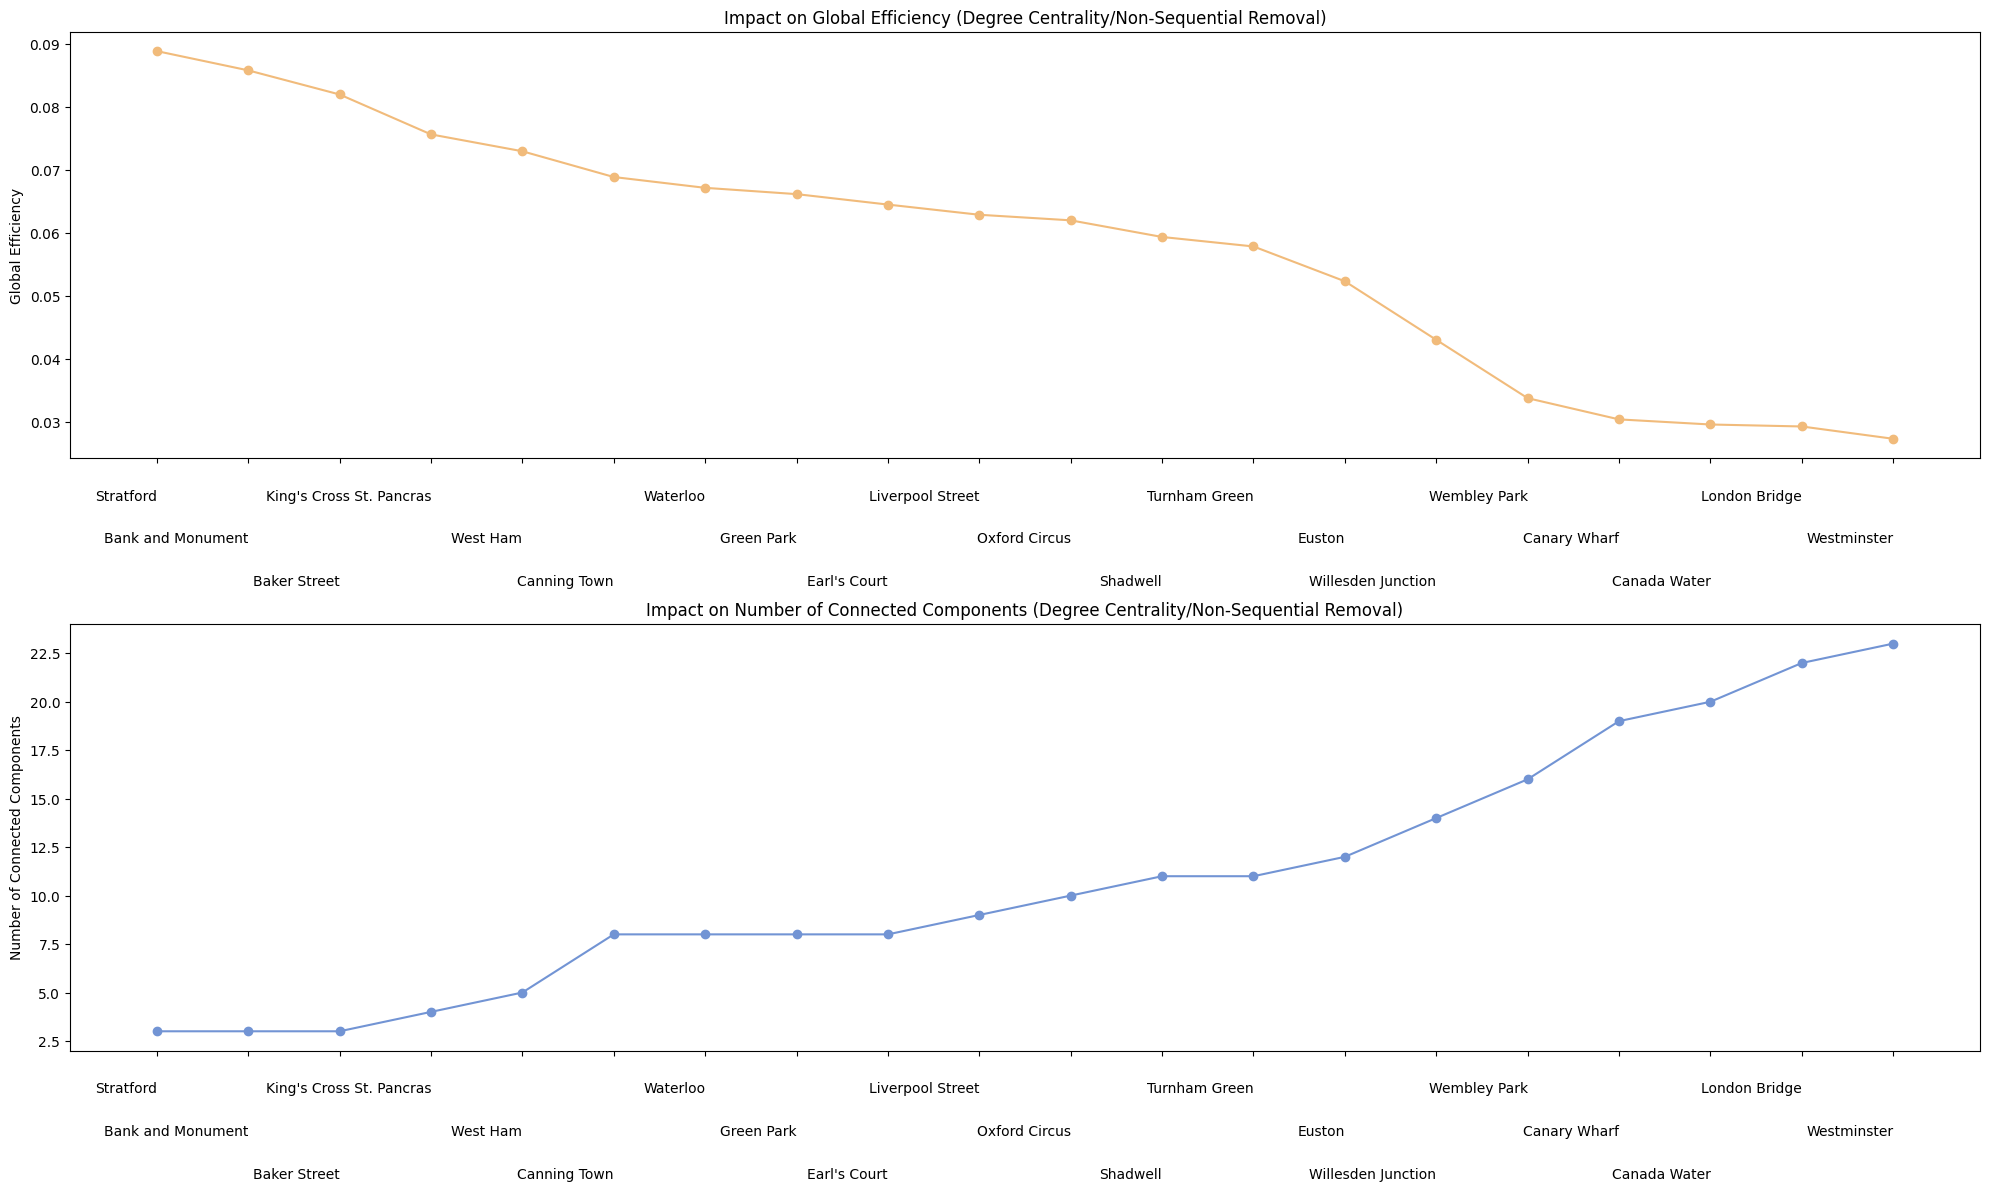

                removed_node  global_efficiency  \
0                  Stratford           0.088917   
1          Bank and Monument           0.085862   
2               Baker Street           0.082033   
3   King's Cross St. Pancras           0.075700   
4                   West Ham           0.073022   
5               Canning Town           0.068935   
6                   Waterloo           0.067219   
7                 Green Park           0.066221   
8               Earl's Court           0.064562   
9           Liverpool Street           0.062945   
10             Oxford Circus           0.062061   
11                  Shadwell           0.059421   
12             Turnham Green           0.057916   
13                    Euston           0.052387   
14        Willesden Junction           0.043097   
15              Wembley Park           0.033840   
16              Canary Wharf           0.030471   
17              Canada Water           0.029661   
18             London Bridge   

In [65]:
# Prepare to store the results
results = {
    'removed_node': [],
    'global_efficiency': [],
    'number_of_connected_components': []
}
london_graph3a_copy = london_graph3a.copy()
# Remove nodes non-sequentially and calculate the measures
for node in top_10_nodes_by_degree:
     
    # Remove the node
    london_graph3a_copy.remove_node(node)
    
    # Calculate global efficiency
    efficiency = nx.global_efficiency(london_graph3a_copy)
    
    # Calculate the number of connected components
    num_connected_components = nx.number_connected_components(london_graph3a_copy)
    
    # Append the results
    results['removed_node'].append(node)
    results['global_efficiency'].append(efficiency)
    results['number_of_connected_components'].append(num_connected_components)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the impact of node removal on global efficiency and number of connected components
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Global efficiency plot
axs[0].plot(results_df['removed_node'], results_df['global_efficiency'], marker='o', color=gbp_colors[0])
axs[0].set_title('Impact on Global Efficiency (Degree Centrality/Non-Sequential Removal)')
#axs[0].set_xlabel('Removed Node')
axs[0].set_ylabel('Global Efficiency')
#axs[0].tick_params(axis='x', rotation=90)

# Number of connected components plot
axs[1].plot(results_df['removed_node'], results_df['number_of_connected_components'], marker='o', color=gbp_colors[7])
axs[1].set_title('Impact on Number of Connected Components (Degree Centrality/Non-Sequential Removal)')
#axs[1].set_xlabel('Removed Node')
axs[1].set_ylabel('Number of Connected Components')
#axs[1].tick_params(axis='x', rotation=90)

# Stagger the x-axis labels between two lines
for ax in axs:
    labels = ax.get_xticklabels()  # Get x labels
    for i, label in enumerate(labels):
        if i % 3 == 0:  # Even index labels
            label.set_y(-0.05)
            label.set_x(+1.05)  # Move even index labels up
        elif i % 3 == 1:
            label.set_y(-0.15)
            label.set_x(-0.05)
        else:  # Odd index labels
            label.set_y(-0.25)  # Move odd index labels down
            label.set_x(-0.15)
    ax.set_xticklabels(labels, rotation=0, ha="right")  # Set new labe

plt.tight_layout()
plt.show()

# Save results to a CSV file
results_df.to_csv('degree_centrality_non_sequential_removal_impact.csv', index=False)

# Display the DataFrame
print(results_df)